Having built machine learning products at two different companies with very different engineering cultures, I've made all of the following wrong assumptions

- All other data orgs do things like my company, so we're doing fine.
- My org is way behind other orgs.
- My org is uniquely advanced, so we can rest on our laurels.


In order to escape the small bubble of my existence, I posted a survey in May 2019 to a private slack group and on Twitter. The survey was designed to learn about the production lifecycle of machine learning models at other companies. If you would like to see the survey questions for yourself (and fill it out!), it is live [here](https://forms.gle/1P8kkZpB1KYwJMfZ9).

Perhaps it is due to the small sample size of the survey (40 respondents as of this writing), but I'm happy to report that data orgs are all over the place. The strongest conclusion that I can draw is that there's always room for improvement in the production ML process.

Despite the small sample size, I will delve into some of the findings, particularly those that I found surprising. If you would like to look at the raw data, the results are available at [this Google Sheet](https://docs.google.com/spreadsheets/d/1P4yzShTo7Le9nCq7MLiIMD-sYphGYlSgNtvE9hFcMEw/edit?usp=sharing).

## Data Cleansing

Survey data is typically a pain to munge in pandas, and this scenario is no different. Apologies for the long, fairly boring code below. I will make a quick shoutout to:

- [bidict](https://bidict.readthedocs.io/en/master/): This library allows you to create one-to-one dictionaries in Python. This means that every value only belongs to one key which allows you to translate long strings to [slugs](https://stackoverflow.com/questions/427102/what-is-a-slug-in-django) and vice versa.
- pandas [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html): This was helpful for mapping binned ranges in survey responses (1-4, 5-10, 10-20, etc...) to ordered categories which allows for easy sorting later on.

In [1]:
%config InlineBackend.figure_format = 'retina'

from altair import datum
from bidict import bidict
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

plt.ion()

In [2]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 14

In [3]:
df = pd.read_csv("responses_anon.csv")

In [4]:
renames = bidict({
    "Does your company train and use machine learning models?": "train_models",
    "What types of machine learning problems are worked on at your company?": "problem_types",
    "How do the majority of models get retrained?": "retrain_method",
    "How often do the majority of models get retrained?": "retrain_frequency",
    "How do the outputs of the models get served? (check all that apply)": "output_methods",
    "Roughly how many different models are serving outputs?": "num_models",
    "Which categories of performance do you track?": "perf_tracking_cats",
    "How is the model performance tracked? (check all that apply)": "perf_tracking_methods",
    "How often do you check model performance?": "perf_checking_frequency",
    "How big is your company?": "company_size",
    "How many people are training and/or deploying ML models at your company?": "num_ml_employees",
    "Can I reach out to you for follow-up questions?": "can_i_followup",
    "Are you interested in the results of this survey?": "interested_in_results",
    "If yes to either of the above, what is your email address?": "email"
})
df = df.rename(columns=renames)

In [5]:
def split_and_rename(splittable_string, rename_func, delim=";"):
    return [
        rename_func(split) for split 
        in str(splittable_string).split(delim)
    ]

def clean_problem_types(df):
    df["problem_types"] = (
        df["problem_types"]
        .apply(
            lambda x: [
                y.replace("Recommendation systems", "Recommendation Systems")
                for y in x.split(";")
            ]
        )
    )
    return df


def clean_output_methods(df):
    def renamer(val):
        if val.startswith("Outputs are written"):
            return "written_to_db"
        elif val.startswith("An API computes outputs"):
            return "realtime_api"
        elif val.startswith("An API serves"):
            return "precomputed_api"
        else:
            return val
    
    df["output_methods"] = df["output_methods"].apply(split_and_rename, args=(renamer,))
    return df


def clean_num_models(df):
    model_types = CategoricalDtype(
        categories=["1", "2-5", "5-10", "10-20", "20-50", "50+"],
        ordered=True
    )
    df["num_models"] = df["num_models"].astype(model_types)
    return df


def clean_perf_tracking_cats(df):
    def renamer(val):
        if val.startswith("Training"):
            return "training_data"
        if val.startswith("Offline"):
            return "offline_test"
        if val.startswith("Online"):
            return "online"
        if val.startswith("nan"):
            return "none"
        if val.startswith("Post"):
            return "post-hoc"
        else:
            raise ValueError(f"Unknown val: {val}")
    df["perf_tracking_cats"] = df["perf_tracking_cats"].apply(split_and_rename, args=(renamer,))
    return df

def clean_perf_tracking_methods(df):
    def renamer(val):
        if val.startswith("Manual"):
            return "manual"
        if val.startswith("Automated"):
            return "automated_sql_or_script"
        if val.startswith("Custom"):
            return "custom_system"
        if val.startswith("Third"):
            return "third_party"
        if val.startswith("Application"):
            return "logs"
        if val.startswith("Trading"):
            return "aux_metric"
        else:
            raise ValueError(f"Unknown val: {val}")
    df["perf_tracking_methods"] = (
        df["perf_tracking_methods"]
        .apply(lambda x: [renamer(val) for val in str(x).split(";")])
    )
    return df

def clean_perf_checking_frequency(df):
    df["perf_checking_frequency"] = df["perf_checking_frequency"].apply(
        lambda x: str(x).split(";")
    )
    return df

def clean_company_size(df):
    company_size_types = CategoricalDtype(
        categories=["1-10", "11-50", "51-150", "151-500", "500+"],
        ordered=True
    )
    df["company_size"] = df["company_size"].astype(company_size_types)
    return df


def clean_num_ml_employees(df):
    ml_types = CategoricalDtype(
        categories=["1-4", "5-10", "11-24", "25-49", "50-100", "100+"],
        ordered=True
    )
    df["num_ml_employees"] = df["num_ml_employees"].astype(ml_types)
    return df

    
def clean(df):
    df = clean_problem_types(df)
    df = clean_output_methods(df)
    df = clean_num_models(df)
    df = clean_perf_tracking_cats(df)
    df = clean_perf_tracking_methods(df)
    df = clean_perf_checking_frequency(df)
    df = clean_company_size(df)
    df = clean_num_ml_employees(df)
    return df

In [6]:
df = clean(df)

## Respondent Context

Before looking at the machine learning-specific questions in the survey, let's look at some demographics of the survey respondents. We can see that the majority of the respondents come from larger companies.

(_Author's note: You can tell that I've only worked at startups by the low bins of company sizes that I provided in the survey. Yay for survey bias._)

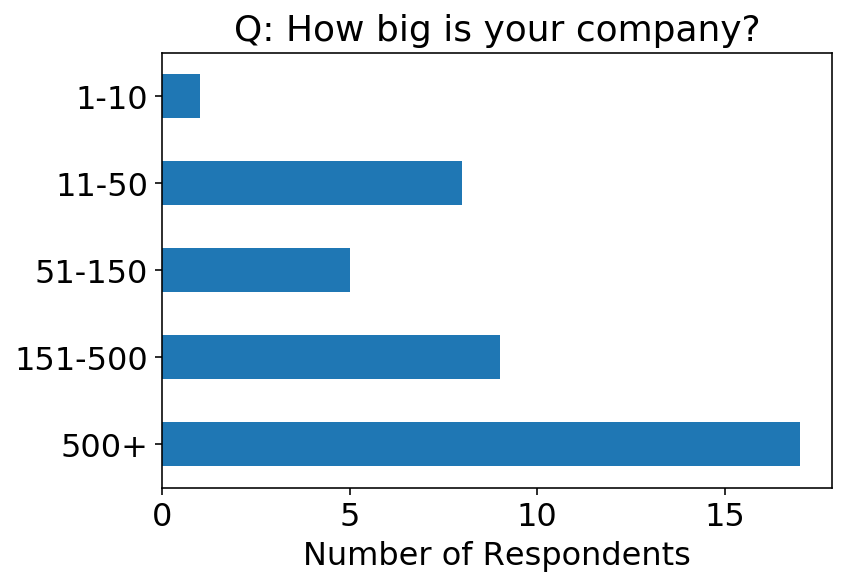

In [7]:
ax = (
    df
    .groupby("company_size")
    .size()
    .sort_index(ascending=False)
    .plot
    .barh()
);
ax.set_xlabel("Number of Respondents");
ax.set_ylabel("");
ax.set_title(f"Q: {renames.inverse['company_size']}");

On the other hand, there tend to be fewer data people deploying ML models at these companies.

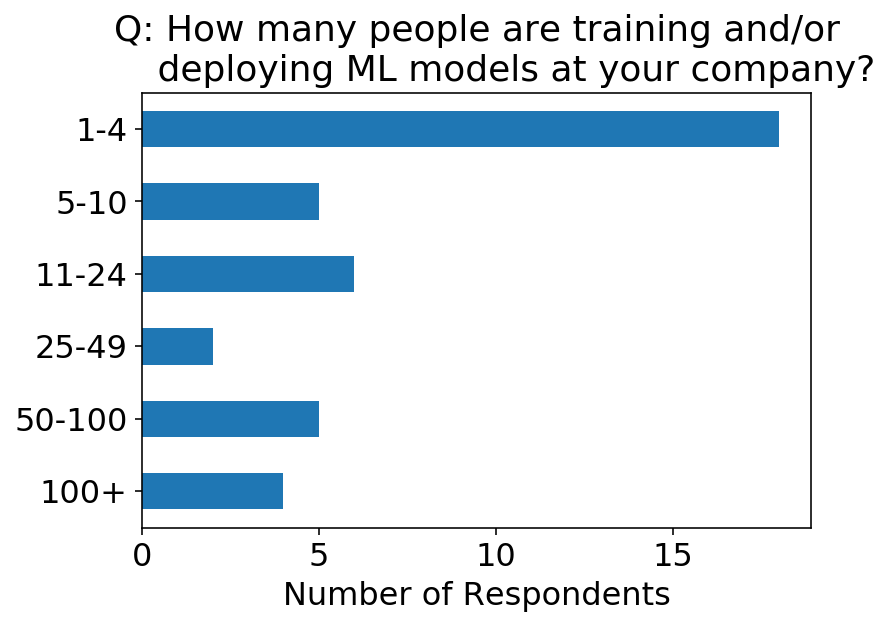

In [8]:
ax = (
    df
    .groupby("num_ml_employees")
    .size()
    .sort_index(ascending=False)
    .plot
    .barh()
);
ax.set_xlabel("Number of Respondents");
ax.set_ylabel("");
title = renames.inverse['num_ml_employees']
title = "and/or\n      ".join(title.split("and/or"))
ax.set_title(f"Q: {title}");

We can look at a heat map of the above two questions. As a sanity check, it's good to see that we don't really have respondents saying there are more ML employees than company employees. I was also impressed to see that there are 4 places with 100+ employees deploying ML models!

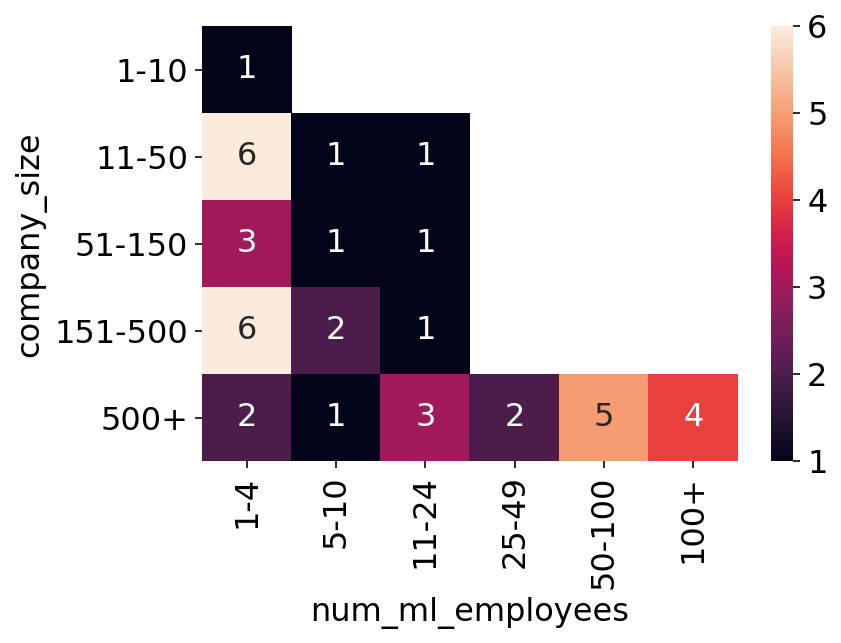

In [9]:
sns.heatmap(
    df
    .groupby(["company_size", "num_ml_employees"])
    .size()
    .unstack(level=1), 
    annot=True
);

The survey also asked "Roughly how many different models are serving outputs?". Below we see the heatmap of this question on the y-axis versus the number of ML employees on the x-axis. This gives us some sort of an understanding of how many people per models there are at the company.

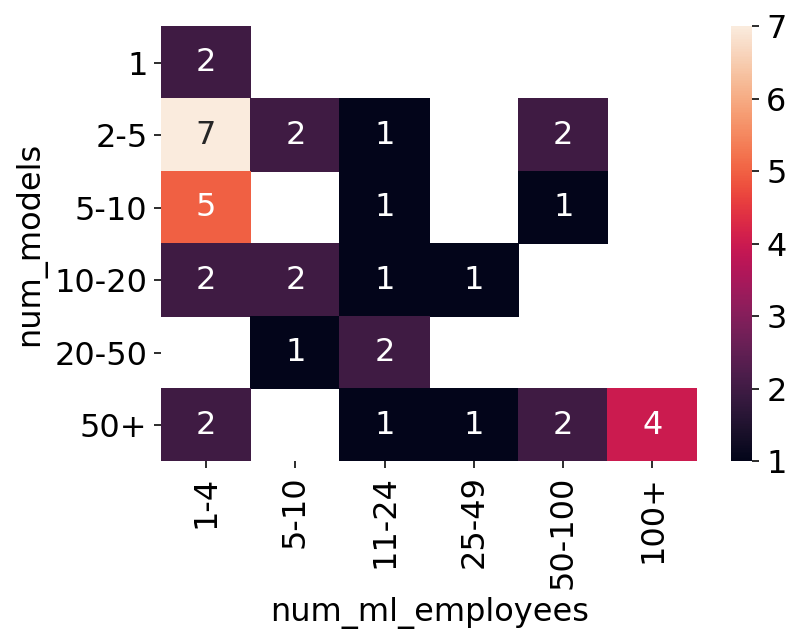

In [10]:
sns.heatmap(
    df
    .groupby(["num_models", "num_ml_employees"])
    .size()
    .unstack(level=1), 
    annot=True
);


## Model Training

When I started at my last job, I inherited an ML system that required training a model locally, scp-ing the pickled model up to an EC2 instance, and restarting the API on that instance to have it pick up the new model. On the one hand, this was pretty terrifying to do on a production service, and I definitely fucked the process up more than once. On the other hand, we were running an experiment to see if the model was even worth it, so maybe this could be considered us adhering to not prematurely optimizing. Nevertheless, the model won the experiment, and we eventually setup automatic batch retraining of the model.

I guess I just assumed that because I had eventually set this up, other people had, too. By the question responses below, that does not appear to be the case. There could be a lot of explanations, though. It's a hell of a lot of work to get to the point where _any_ other system or person is consuming the outputs of your model. It's even more work to automate the production workflow. Some respondents' orgs may be young. Alternatively, some models rarely need to be retrained (e.g. word2vec from scratch).

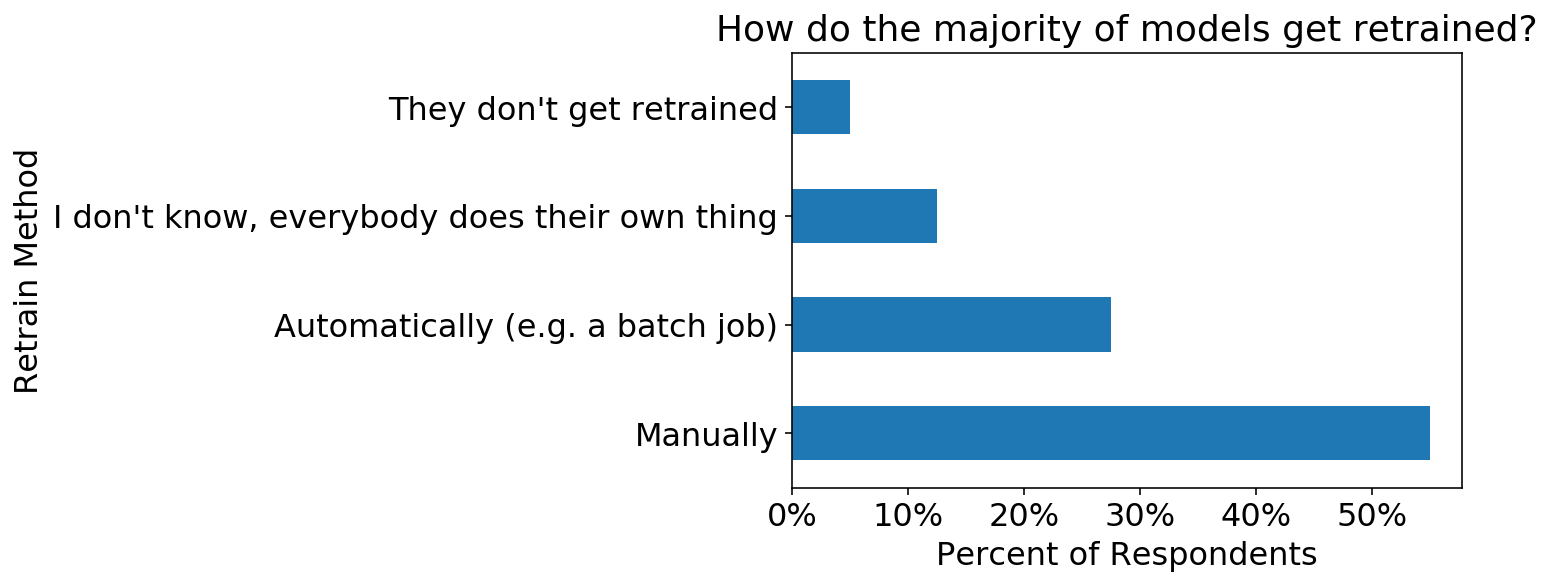

In [11]:
ax = df.retrain_method.value_counts(normalize=True).plot.barh();
ax.set_title(renames.inverse["retrain_method"]);
ax.set_ylabel("Retrain Method");
ax.set_xlabel("Percent of Respondents");
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

The next question concerns how often the models get retrained. We see here that the most popular response is Randomly, followed by Monthly which is probably not surprising given that many models are retrained manually. One thing I should point out is that different types of models require different training frequencies. Recommender systems' performance vastly improves with _any_ data on a user (the so-called "cold start" problem). As such, one should retrain them as frequently as possible on the latest data. A few-featured logistic regression may not benefit much from retraining due to the model's complexity already being saturated on smaller data.

At my last company, we strove for daily model retraining simply because we could (the data was small), and we could pick up errors in the data quicker this way. 

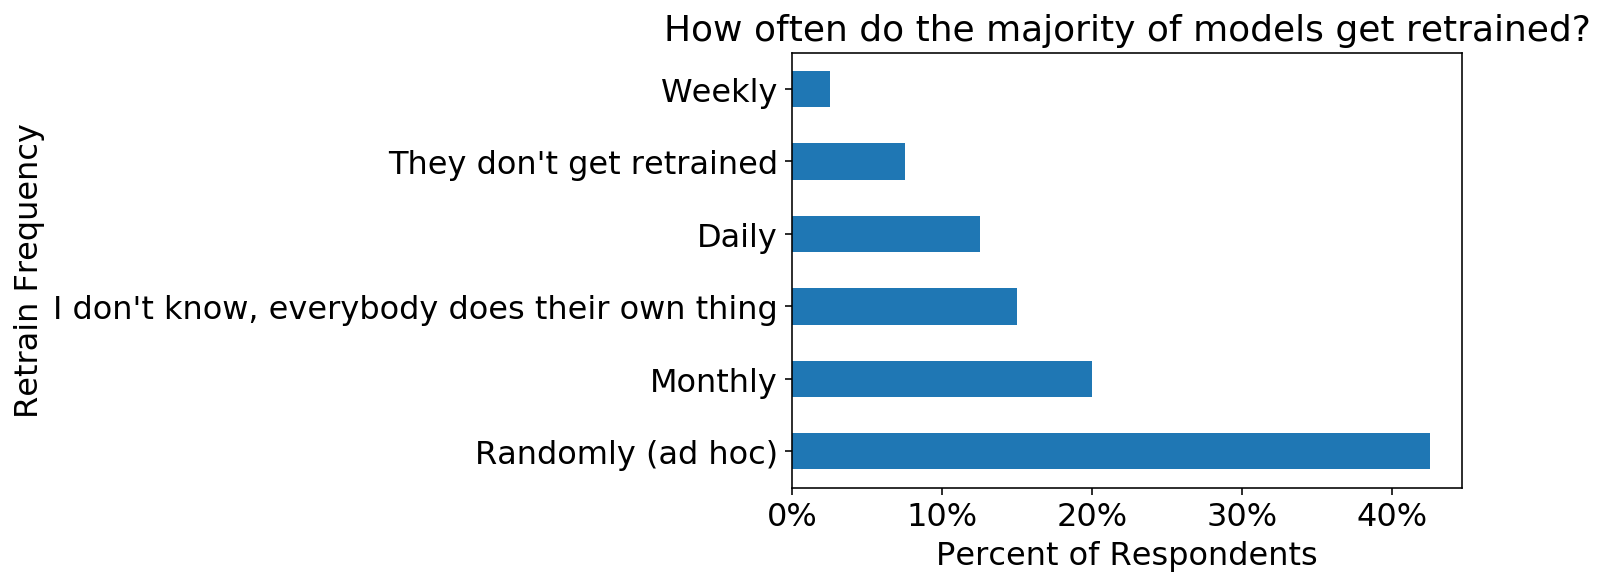

In [12]:
ax = df.retrain_frequency.value_counts(normalize=True).plot.barh();
ax.set_title(renames.inverse["retrain_frequency"]);
ax.set_ylabel("Retrain Frequency");
ax.set_xlabel("Percent of Respondents");
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

We can split the above two questions and look at the retraining frequency for models that are retrained automatically versus manually. As expected, the majority of manually retrained models are retrained with random frequency, while automatically retrained models have a set frequency.

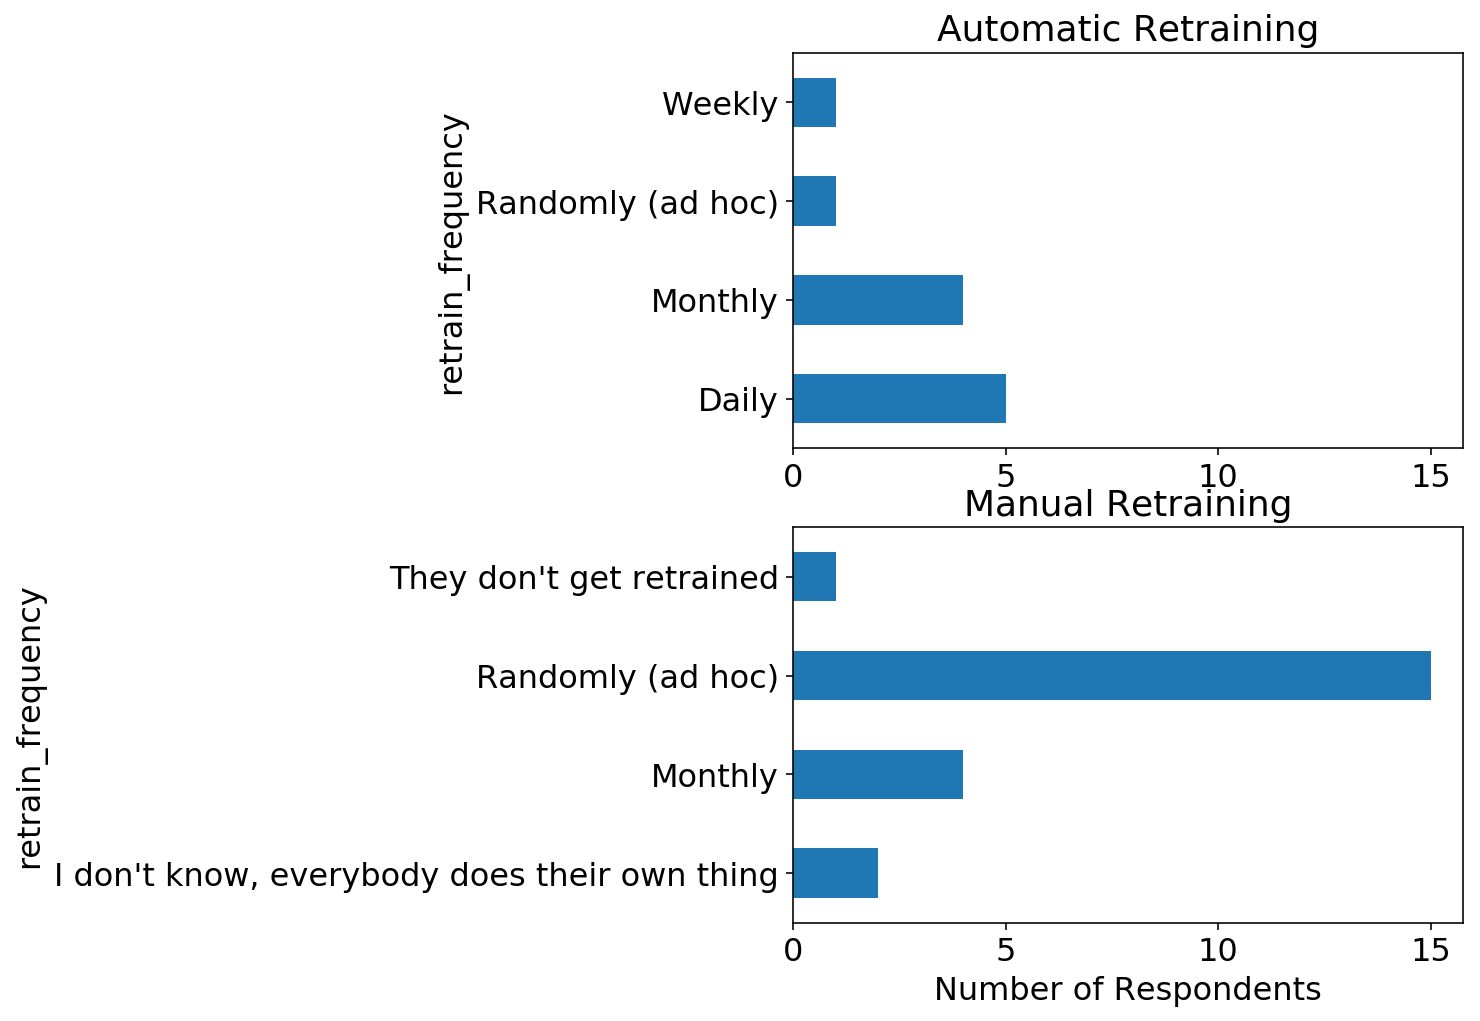

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8));
axs = axs.flatten();
df.query("retrain_method == 'Automatically (e.g. a batch job)'").groupby("retrain_frequency").size().plot.barh(ax=axs[0]);
df.query("retrain_method == 'Manually'").groupby("retrain_frequency").size().plot.barh(ax=axs[1]);
axs[0].set_title("Automatic Retraining");
axs[1].set_title("Manual Retraining");
axs[1].set_xlabel("Number of Respondents");

# Set same x-scale for both axes
xlims = list(zip(*[ax.get_xlim() for ax in axs]))
xlim = min(xlims[0]), max(xlims[1])
axs[0].set_xlim(xlim);
axs[1].set_xlim(xlim);

## Model Serving and Monitoring

Lest I was sounding snobby in the previous section talking about peoples' random, manual retraining, I was totally impressed with the sophistication of respondents' model serving and monitoring setups. The first question I asked about model serving was 

_How do the outputs of the models get served? (check all that apply)_

with the following options:

- Outputs are written to a database and some other system uses them
- An API serves pre-computed outputs
- An API computes outputs in realtime

Looking at the chart below, it's impressive to see that 60% of respondents' companies have models deployed as realtime APIs. This is quite difficult in that the model likely needs to meet typical engineering SLAs like low latency and uptime.

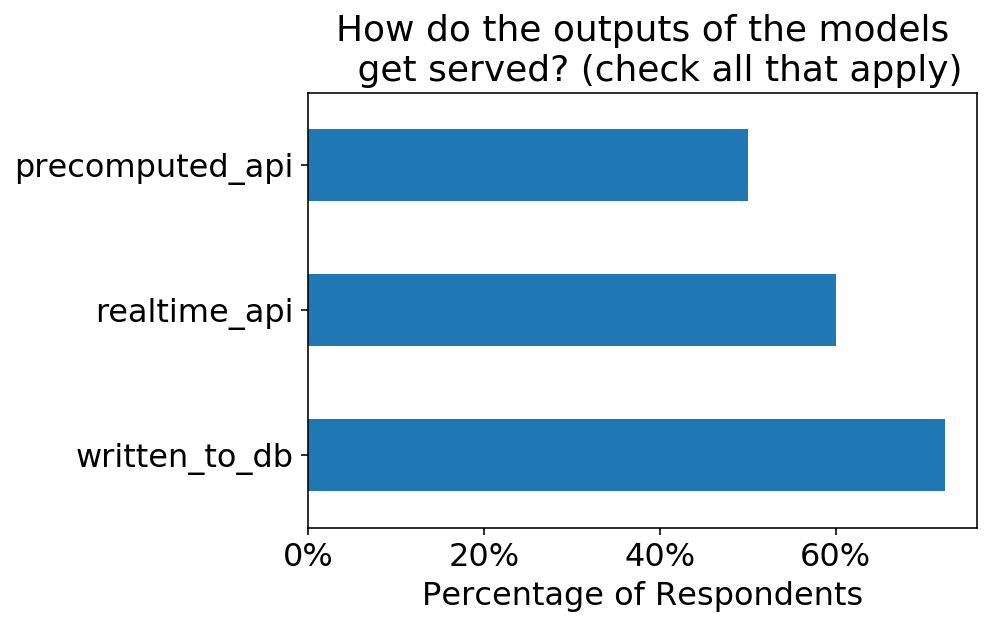

In [14]:
total_respondents = len(df)
ax = (
    df
    .explode("output_methods")
    .query("output_methods in ['precomputed_api', 'realtime_api', 'written_to_db']")
    ["output_methods"]
    .value_counts() / total_respondents
).plot.barh();
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format));
ax.set_title("models\n  ".join(renames.inverse["output_methods"].split("models")));
ax.set_xlabel("Percentage of Respondents");

I also asked about the metrics that are monitored, along with how they're monitored:

Q: _What categories of performance do you track?_

A:

- Training data metrics (e.g. a classifier's AUC on the training data)
- Offline test data metrics (e.g. a classifier's AUC on held out test data)
- Online metrics (e.g. comparing predictions at the time of model serving to outcomes)

Q: _How is the model performance tracked? (check all that apply)_

A:

- Manual SQL queries / scripts
- Automated SQL queries / scripts
- Custom-built monitoring system
- Third-party system

Again, I'm impressed by the level of sophistication. Online metrics are essential to track once a model is in production, but they are also the most difficult metrics to track. Still, >60% of respondents track this data.

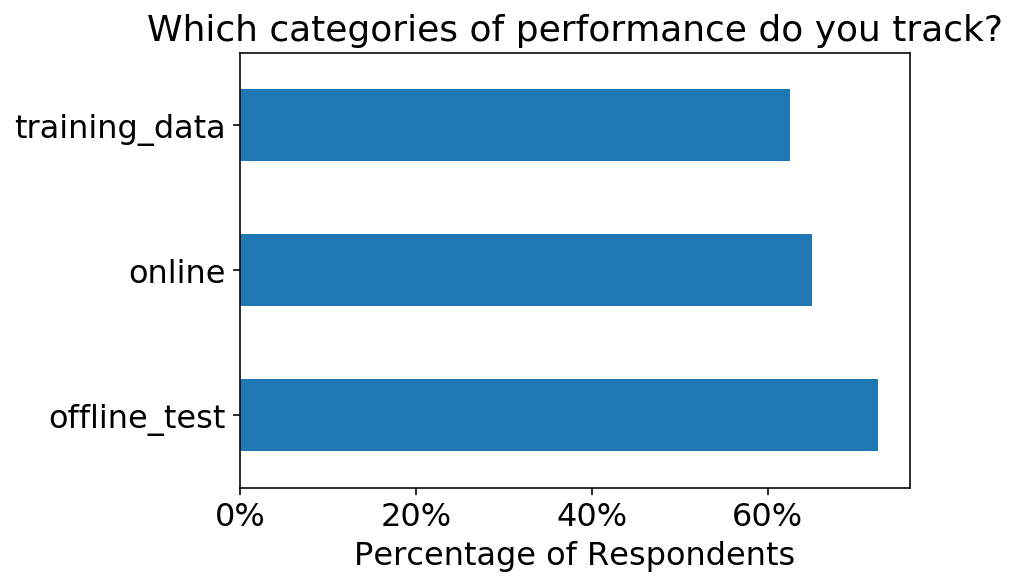

In [15]:
total_respondents = len(df)
ax = (
    df
    .explode("perf_tracking_cats")
    .query("perf_tracking_cats in ['training_data', 'offline_test', 'online']")
    ["perf_tracking_cats"]
    .value_counts() / total_respondents
).plot.barh();
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format));
ax.set_title(renames.inverse["perf_tracking_cats"]);
ax.set_xlabel("Percentage of Respondents");

As well, it's cool to see that >50% of respondents have setup either automated scripts or custom monitoring systems. 

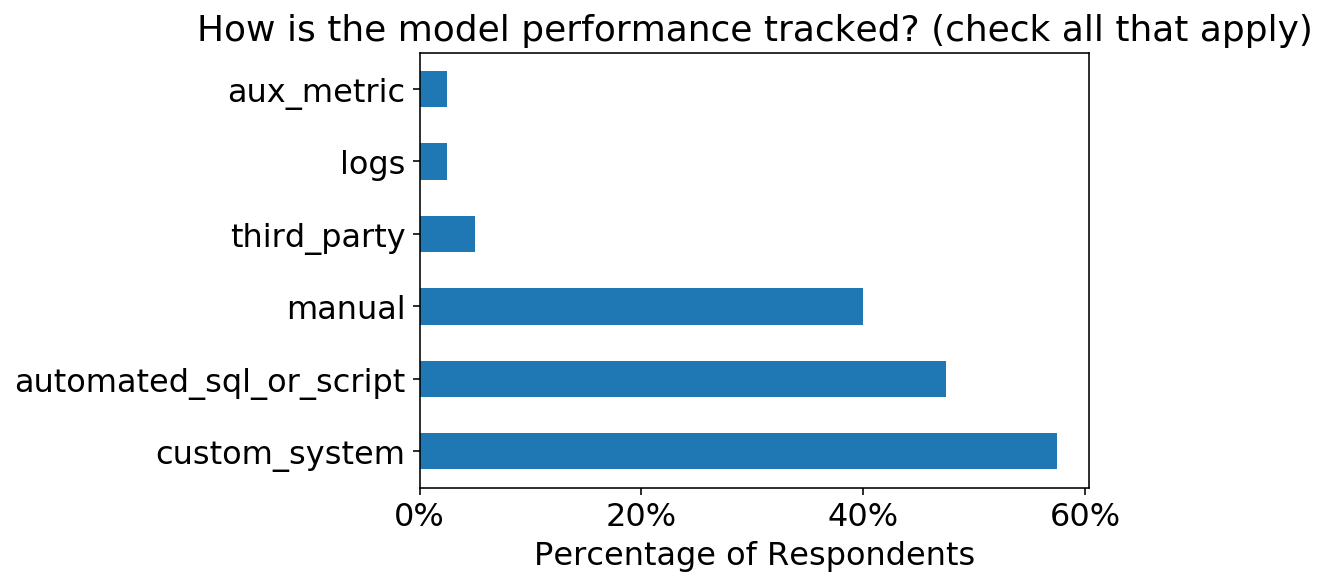

In [16]:
total_respondents = len(df)
ax = (
    df["perf_tracking_methods"]
    .explode()
    .value_counts() / total_respondents
).plot.barh();
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format));
ax.set_title(renames.inverse["perf_tracking_methods"]);
ax.set_xlabel("Percentage of Respondents");

I also asked how often the model performance is tracked. We can see that the most popular frequency is Weekly, which is the typical cadence that I have setup automatic tracking for these things in the past. Whether or not I would actually _look_ at the metrics each week is a different story...

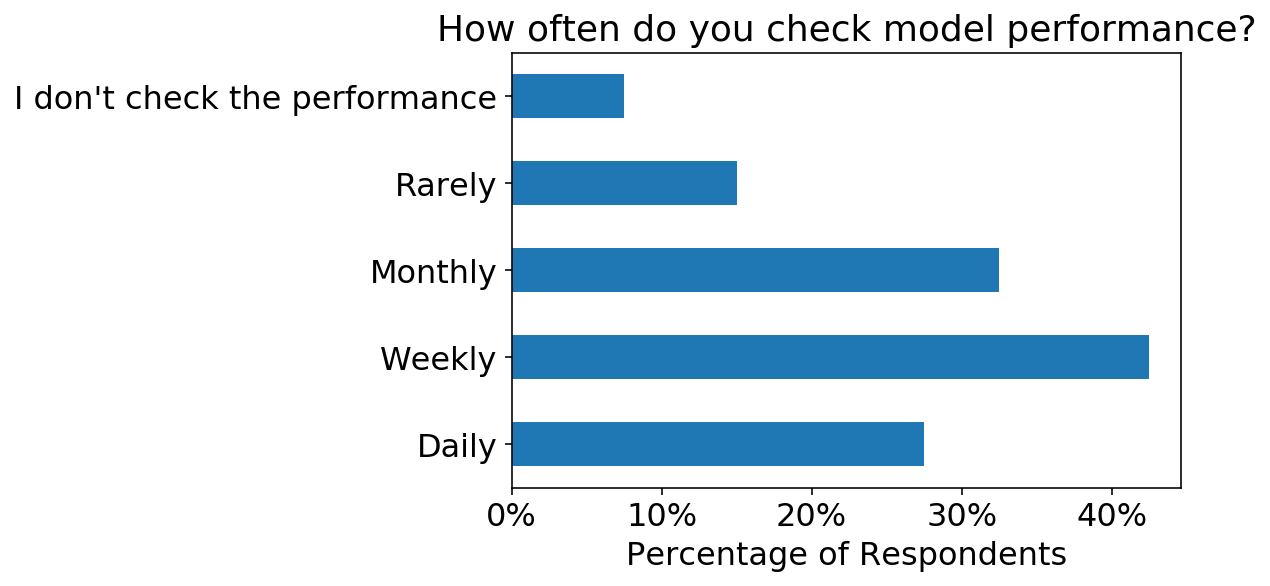

In [17]:
total_respondents = len(df)
opts = [
    "Daily", 
    "Weekly", 
    "Monthly", 
    "Rarely", 
    "I don't check the performance"
]
ax = (
    df
    .explode("perf_checking_frequency")
    .query("perf_checking_frequency in @opts")
    ["perf_checking_frequency"]
    .value_counts() / total_respondents
).loc[opts].plot.barh();
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format));
ax.set_title(renames.inverse["perf_checking_frequency"]);
ax.set_xlabel("Percentage of Respondents");